In [582]:
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from pathlib import Path
import scanpy as sc
import geopandas as gpd
from sklearn_ann.kneighbors.annoy import AnnoyTransformer
# to install %pip install -q "scanpy" "sklearn-ann[annoy]"
import matplotlib.pyplot as plt
import scanpy.external as sce
import random


In [583]:
# set global seed
SEED = 1337
random.seed(SEED)

In [584]:
segmentation_path = Path("/Users/janzules/Roselab/Spatial/dietary_project/data/segmented_data/")
adata_file     = segmentation_path / "combined_adata.h5ad"
geneList = segmentation_path / "Gene_lists"
fig_out = Path("/Users/janzules/Roselab/Spatial/dietary_project/figures/cell_segmentation_result_analysis/Improving_clustering/")
ST_sample_org = sc.read_h5ad(adata_file)

In [585]:
# Cleaning
# Identify mitochondrial genes (prefix 'MT-' for human)
ST_sample_org.var['mito'] = ST_sample_org.var_names.str.startswith('mt-')

#  Run QC metrics
sc.pp.calculate_qc_metrics(
    ST_sample_org, 
    qc_vars=['mito'], 
    inplace=True, 
    log1p=False
)

sc.pp.filter_genes(ST_sample_org, min_cells=10)
# sc.pp.filter_cells(ST_sample_org, min_genes = 100)
ST_sample_org = ST_sample_org[
    (ST_sample_org.obs['total_counts'] >= 100) &
    (ST_sample_org.obs['pct_counts_mito'] <= 15)
].copy()

# Sub_sampling_profiling


In [586]:
subset_PTEN = ST_sample_org[ST_sample_org.obs['sample_id'].isin(['F07838', 'F07837'])].copy()

In [587]:
# Random cells - 3k
# rng = np.random.RandomState(SEED)
# rng.choice(100, 10, replace=False)
n_cells = 40000
if subset_PTEN.n_obs > n_cells:
    selected_indices = np.random.choice(subset_PTEN.n_obs, n_cells, replace=False)
    ST_sample = subset_PTEN[selected_indices, :].copy()

ST_sample.obs['id']

ID_1282421    ID_1282421
ID_1398948    ID_1398948
ID_1639162    ID_1639162
ID_1323799    ID_1323799
ID_1365887    ID_1365887
                 ...    
ID_1521350    ID_1521350
ID_1474550    ID_1474550
ID_1181851    ID_1181851
ID_1261117    ID_1261117
ID_1550392    ID_1550392
Name: id, Length: 40000, dtype: object

In [588]:
ST_sample.obs['sample_id'].unique()

['F07837', 'F07838']
Categories (2, object): ['F07837', 'F07838']

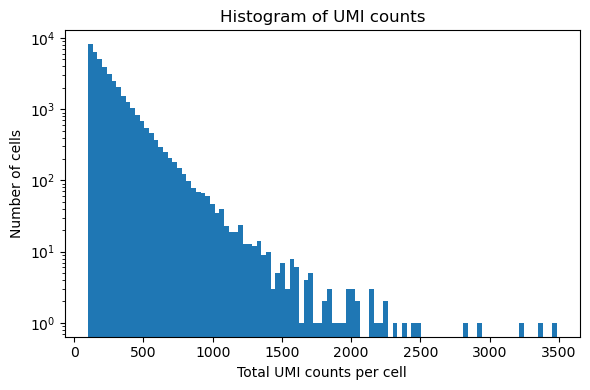

In [589]:
plt.figure(figsize=(6,4))
plt.hist(ST_sample.obs['total_counts'], bins=100)
plt.yscale('log')              # log y‐axis to see the tail more clearly
plt.xlabel('Total UMI counts per cell')
plt.ylabel('Number of cells')
plt.title('Histogram of UMI counts')
plt.tight_layout()
plt.show()

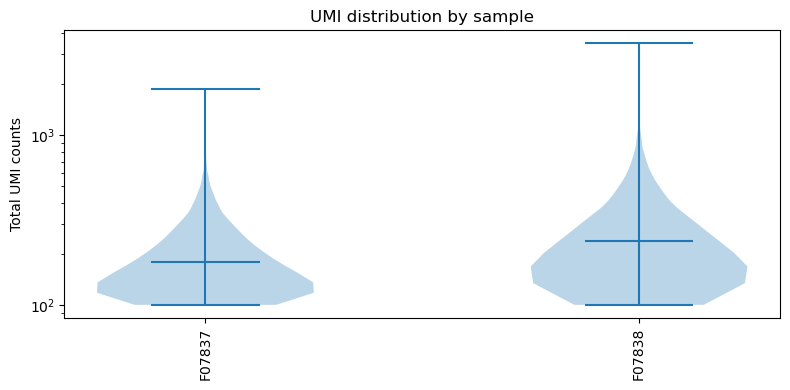

In [590]:
# prepare data
df = ST_sample.obs[['sample_id','total_counts']]

# build one violin per sample
samples = df['sample_id'].cat.categories
data = [ df.loc[df['sample_id']==s, 'total_counts'] for s in samples ]

plt.figure(figsize=(8,4))
plt.violinplot(data, showmedians=True)
plt.xticks(range(1,len(samples)+1), samples, rotation=90)
plt.yscale('log')
plt.ylabel('Total UMI counts')
plt.title('UMI distribution by sample')
plt.tight_layout()
plt.show()


In [591]:
# Saving count data
ST_sample.layers["counts"] = ST_sample.X.copy()

In [592]:
#Cell-cycle scoring
with open(f"{geneList}/cc_mouse_cycle_genes.json") as jf:
    cc = json.load(jf)
s_genes_mouse   = cc["s_genes"]
g2m_genes_mouse = cc["g2m_genes"]


sc.tl.score_genes_cell_cycle(
    ST_sample,
    s_genes   = s_genes_mouse,
    g2m_genes = g2m_genes_mouse,
    use_raw   = False
)

In [593]:
# # Immune scoring
# immune_genes = [
#     # T cells
#     "Cd3e",   # pan-T cell marker (TCR complex)
#     "Cd4",    # CD4+ T helper cells
#     "Cd8a",   # CD8+ cytotoxic T cells
#     "Foxp3",  # regulatory T cells (Tregs)
#     "Pdcd1",  # exhausted T cells (PD-1)
#     "Ctla4",  # inhibitory receptor, Tregs, exhausted T cells
#     "Ptprc"   # CD45

#     # NK cells
#     "Ncr1",   # NK cell activating receptor
#     "Prf1",   # perforin (cytotoxic granule, NK and CD8 T cells)
#     "Gzmb",   # granzyme B (cytotoxic granule, NK and CD8 T cells)
#     "Ifng",   # interferon-gamma (produced by NK and T cells)

#     # B cells
#     "Cd79a",  # B-cell receptor complex
#     "Cd19",   # pan-B cell marker
#     "Ms4a1",  # CD20 (B-cell marker)

#     # Macrophages / Monocytes
#     "Adgre1", # F4/80 (macrophage marker)
#     "Itgam",  # CD11b (macrophages, monocytes, neutrophils)
#     "Csf1r",  # macrophage colony-stimulating factor receptor
#     "Mrc1",   # CD206, M2 macrophages (pro-tumor TAMs)

#     # Dendritic cells (DCs)
#     "Itgax",  # CD11c (dendritic cells)
#     "H2-Ab1", # MHC class II (antigen presentation, DCs, macrophages)
#     "Cd74",   # invariant chain for MHC II (antigen presentation)

#     # MDSC / Neutrophils
#     "Ly6g",   # neutrophils, granulocytic-MDSCs
#     "S100a8", # neutrophils, MDSCs
#     "S100a9", # neutrophils, MDSCs
#     "Nos2",   # M1 macrophages, anti-tumor, nitric oxide synthase
#     "Arg1",   # M2 macrophages, immunosuppressive MDSCs

#     # Mast cells
#     "Kit",    # stem cell factor receptor (mast cells)
#     "Fcer1a", # high-affinity IgE receptor (mast cells)
#     "Cpa3",   # mast cell-specific protease

#     # General inflammatory mediators
#     "Il1b",   # pro-inflammatory cytokine (macrophages, neutrophils)
#     "Tnf"     # tumor necrosis factor alpha (broad immune activation)
# ]
# len(immune_genes)

In [594]:
core_immune_genes = ["Ptprc", "Cd3e", "Cd4" "Cd79a", "Itgam", "Ly6g", "Ncr1", "Arg1", "H2-Abl", "Adgre1", "Mrcl", "Nos2", "csflr"]

core_immune_genes = [g for g in core_immune_genes if g in ST_sample.var_names]
sc.tl.score_genes(
    ST_sample,
    gene_list=core_immune_genes,
    score_name="Immune_score",
    ctrl_size=50
)

In [595]:

# pten genes from Glaviano et al. 2023
pten_downstream_genes = [
    # PI3K → AKT → mTOR core cascade
    "Pik3ca",  # PI3K catalytic subunit alpha
    "Pik3cb",  # PI3K catalytic subunit beta
    "Pik3cd",  # PI3K catalytic subunit delta
    "Pik3cg",  # PI3K catalytic subunit gamma
    "Akt1",    # AKT serine/threonine kinase 1
    "Akt2",    # AKT serine/threonine kinase 2
    "Akt3",    # AKT serine/threonine kinase 3
    "Mtor",    # mechanistic target of rapamycin (mTOR)

    # Direct AKT substrates / pathway read-outs
    "Foxo1",   # Forkhead box O1 (transcription factor, inhibited by AKT)
    "Foxo3",   # Forkhead box O3 (transcription factor, inhibited by AKT)
    "Gsk3b",   # Glycogen synthase kinase 3 beta (inhibited by AKT)
    "Bad",     # BCL2-associated agonist of cell death (pro-apoptotic, inhibited by AKT)
    "Mdm2",    # E3 ubiquitin-protein ligase Mdm2 (p53 regulation, activated by AKT)
    "Tsc2",    # Tuberous sclerosis complex 2 (TSC complex, inhibited by AKT)
    "Cdkn1a",  # Cyclin-dependent kinase inhibitor 1A (p21, AKT-regulated)
    "Cdkn1b",  # Cyclin-dependent kinase inhibitor 1B (p27, AKT-regulated)

    # mTORC1 translational targets
    "Rps6kb1", # Ribosomal protein S6 kinase beta-1 (S6K1, downstream of mTORC1)
    "Eif4ebp1",# Eukaryotic translation initiation factor 4E binding protein 1 (4E-BP1)
    "Rps6",    # Ribosomal protein S6 (target of S6K1 phosphorylation)

    # Cell-cycle & growth genes induced downstream
    # "Myc",     # MYC proto-oncogene (cell growth, proliferation)
    "Ccnd1",   # Cyclin D1 (G1/S cell cycle transition)
    "Cdk4",    # Cyclin-dependent kinase 4 (partners with Cyclin D)
    "Cdk6",    # Cyclin-dependent kinase 6 (partners with Cyclin D)
    "Vegfa",   # Vascular endothelial growth factor A (angiogenesis, upregulated by mTOR-HIF1A)
    "Hif1a",   # Hypoxia-inducible factor 1-alpha (upregulated downstream of mTOR)

    # Anti-/pro-apoptotic balance
    "Bcl2",    # B-cell lymphoma 2 (anti-apoptotic)
    "Mcl1",    # Myeloid cell leukemia 1 (anti-apoptotic)
    "Bax",     # BCL2 associated X, apoptosis regulator (pro-apoptotic)
    "Bak1"     # BCL2 antagonist/killer 1 (pro-apoptotic)
]
present_pten = [g for g in pten_downstream_genes if g in ST_sample.var_names]

# based on CHI V. DANG* 1999 - mini review of myc genes
myc_growth     = ["Myc","Ccna2", "Ccnd1", "Ccne1", "Cdk1", "Cdc25a", "Rcc1", "Odc1", "Tert", "Tk1"]
myc_survival   = ["Cdkn2a", "Trp53", "Bax"]
myc_metabolism = ["Ldha", "Cad", "Dhfr", "Eif2s1", "Eif4e", "Rida"]
myc_cap_genes  = myc_growth + myc_survival + myc_metabolism

# 2) compute module scores on the normalized log1p data
sc.tl.score_genes(
    ST_sample,
    gene_list=present_pten,
    score_name="PTENSKO_score",
    ctrl_size = len(present_pten)
)

sc.tl.score_genes(
    ST_sample,
    gene_list=myc_cap_genes,
    score_name="MycCAP_score"
)

In [596]:
# HVG selection
sc.pp.highly_variable_genes(
    ST_sample,
    n_top_genes=3000, #default 2k
    flavor="seurat_v3",
    # batch_key="TMA"
)
# ST_sample = ST_sample[:, ST_sample.var['highly_variable']].copy()

In [597]:
# # Identify cells with total counts > 0 after HVG filtering
# nonzero_cells = np.array(ST_sample.X.sum(axis=1)).flatten() > 0

# # Subset to only nonzero cells
# ST_sample = ST_sample[nonzero_cells, :].copy()

In [598]:
ST_sample.shape

(40000, 18928)

In [599]:
# normalize + log1p
sc.pp.normalize_total(ST_sample)
sc.pp.log1p(ST_sample)

In [600]:
# # 1. Create a numeric code for each sample
# ST_sample.obs['sample_code'] = ST_sample.obs['sample_id'].cat.codes

# # 2. Check the mapping
# print(ST_sample.obs[['sample_id','sample_code']].drop_duplicates().sort_values('sample_code'))


# Regressing out

In [601]:
# ST_sample = Orgdata

In [602]:
# sc.pp.regress_out(
#     ST_sample,
#     keys=['total_counts', 'pct_counts_mito', 'S_score', 'G2M_score']
# )

# sc.pp.regress_out(
#     ST_sample,
#     keys=['total_counts', 'pct_counts_mito', "PTENSKO_score",  "MycCAP_score"]
# )

# sc.pp.regress_out(
#     ST_sample,
#     keys=['total_counts', 'pct_counts_mito', "PTENSKO_score",  "MycCAP_score", "Immune_score",
#          'S_score', 'G2M_score']
# )

# sc.pp.regress_out(
#     ST_sample,
#     keys=['total_counts', 'pct_counts_mito', "Immune_score",
#          'S_score', 'G2M_score']
# )
sc.pp.regress_out(
    ST_sample,
    keys=['total_counts', 'pct_counts_mito', "Immune_score",
         'S_score', 'G2M_score', "PTENSKO_score"]
)
# sc.pp.regress_out(
#     ST_sample,
#     keys=['total_counts', 'pct_counts_mito', "Immune_score",
#          'S_score', 'G2M_score', "MycCAP_score"]
# )
# sc.pp.regress_out(
#     ST_sample,
#     keys=['total_counts', 'pct_counts_mito', "PTENSKO_score",  "MycCAP_score", "Immune_score" ]
# )

# sc.pp.regress_out(
#     ST_sample,
    # keys=['total_counts', 'pct_counts_mito']


In [603]:
# sc.pp.regress_out(
#     ST_sample,
#     keys=['total_counts', 'pct_counts_mito']
# )

In [604]:
 # Scale so each gene has unit variance
# sc.pp.scale(ST_sample, max_value=10)

In [605]:
# PCA with randomized SVD
n_pcs = 50
sc.tl.pca(ST_sample, n_comps=n_pcs, svd_solver="randomized")

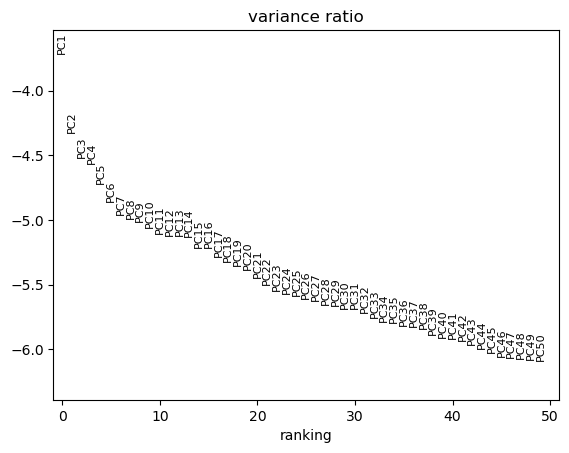

In [606]:
sc.pl.pca_variance_ratio(ST_sample, n_pcs=n_pcs, log=True)

In [607]:
pc_choice = 10

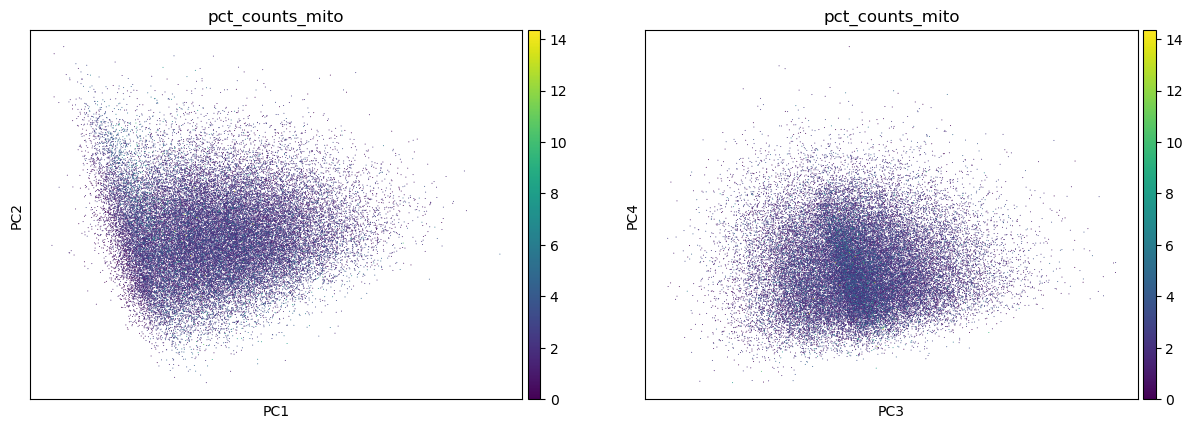

In [608]:
sc.pl.pca(
    ST_sample,
    color=["pct_counts_mito", "pct_counts_mito"],
    dimensions=[(0, 1), (2, 3)],
    ncols=2,
    size=2,
)

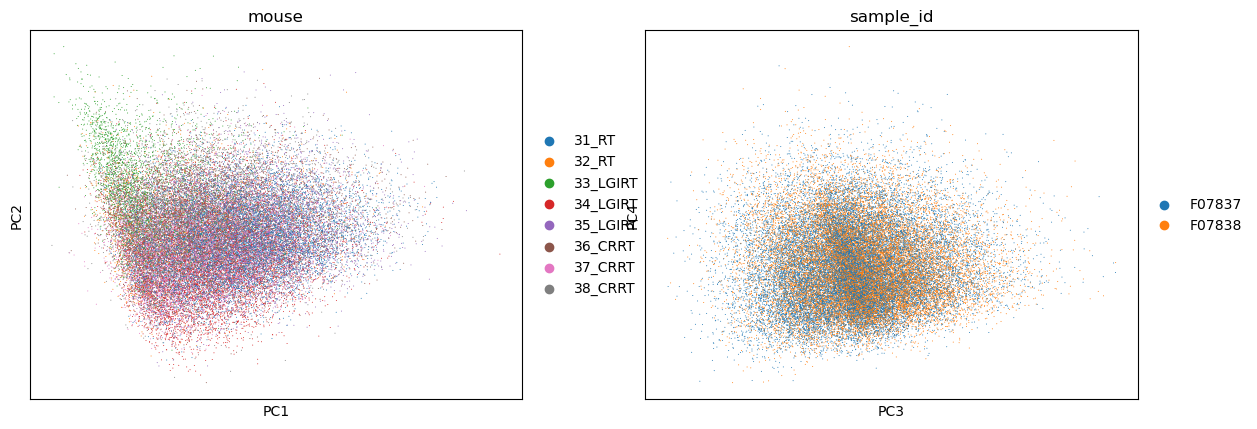

In [609]:
# First the categorical panels (no sorting needed)
sc.pl.pca(
    ST_sample,
    color=["mouse", "sample_id"],
    dimensions=[(0, 1), (2, 3)],
    ncols=2,
    size=2,
    sort_order=False,      # categorical won’t sort anyway
)

In [610]:
# Integration

# sce.pp.harmony_integrate(
#     ST_sample,
#     key='sample_id',
#     basis='X_pca',
#     adjusted_basis='X_pca_harmony'
# )

# sc.pp.neighbors(
#     ST_sample,
#     n_neighbors=30,
#     n_pcs=pc_choice,
#     # use_rep='X_pca_harmony',
#     # transformer=AnnoyTransformer(n_trees=100),
#     method="umap",
#     knn=True
# )

In [ ]:
# Memory efficient
sc.pp.neighbors(
    ST_sample,
    n_neighbors=30,
    n_pcs=pc_choice,
    transformer=AnnoyTransformer(n_trees=100),
    method="umap",
    knn=True
)

In [ ]:
resl = 0.50
sc.tl.leiden(
    ST_sample,
    resolution=resl,
    flavor="igraph",
    directed=False,    # Undirected - forces a two way link
    random_state=1337
)

In [ ]:
sc.tl.umap(
    ST_sample,
    init_pos='random',  # instead of 'spectral'
)

In [ ]:
sc.pl.umap(
    ST_sample,
    color='leiden',    # color by your leiden clusters
    palette='tab20',   # nice large color palette
    size=5,            # small dots for large datasets (~1M cells)
    frameon=False,
    title=f'Leiden Clustering {resl}'
)

In [ ]:
# sc.pl.umap(
#     ST_sample,
#     color='leiden',
#     groups=['1','10'],      # only these labels will be colored
#     palette=['purple','green'],  # match the order of your groups
#     size=20,
#     frameon=False,
#     title='Highlight Clusters'
# )

In [ ]:
sc.pl.umap(
    ST_sample,
    color=['sample_id', 'condition'],
    ncols=3,            # one panel per key
    size=5,             # adjust dot size for visibility
    frameon=False,
    title=[f'Sample ID - {resl}', f'Condition - {resl}']
)


In [ ]:
ST_sample.obs['sample_id'].unique()

In [ ]:
sc.pl.umap(
    ST_sample,
    color=['mouse'],
    ncols=3,            # one panel per key
    size=5,             # adjust dot size for visibility
    frameon=False,
    title=['Mouse']
)


In [ ]:
fig = sc.pl.umap(
    ST_sample,
    color='total_counts',
    cmap='magma',
    vmin=0, vmax=500,
    size=20,
    frameon=False,
    title='UMAP colored by total UMI',
    show=False,
    return_fig=True
)


In [ ]:
sc.pl.umap(
    ST_sample,
    color=["PTENSKO_score", "MycCAP_score"],
    size=5,
    frameon=False,
    cmap="viridis",
    title=["PTEN-SKO module score", "Myc-CAP module score"]
)

In [ ]:
# UMAP overlay - Immune Score
sc.pl.umap(
    ST_sample,
    color="Immune_score",
    size=5,
    frameon=False,
    cmap="viridis",
    title="Immune module score"
)



In [ ]:
sc.pl.umap(
    ST_sample,
    color="Immune_score",
    size=5,
    frameon=False,
    cmap="viridis",
    title="Immune module score",
    show=False  # Important: do not display immediately
)

# Save the current figure at 600 dpi
fig_out = Path("/Users/janzules/Roselab/Spatial/dietary_project/figures/cell_segmentation_result_analysis/Improving_clustering/")
fig_out.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists

plt.gcf().savefig(fig_out / "immune_module_score_umap.png", dpi=600, bbox_inches='tight')
plt.close()

In [ ]:
# Picked markers in the order you’d like them to appear left→right, top→bottom
genes_plot = [
    "Cd3e", "Cd4", "Cd8a", "Foxp3", "Ncr1",
    "Gzmb", "Ms4a1", "Adgre1", "Mrc1", "Itgax"
]

# Scanpy UMAP overlay
sc.pl.umap(
    ST_sample,
    color=genes_plot,
    ncols=5,                 # five panels per row → 2 rows for 10 genes
    size=5,                  # dot size – tweak for your DPI
    frameon=False,
    cmap="viridis",          # continuous colour map
    vmax="p99",              # clip extreme outliers for better contrast
    vmin="p01",
    layer = "counts",
    title=genes_plot         # one title per panel
)


In [ ]:
sc.pl.umap(
    ST_sample,
    color='leiden',    # color by your leiden clusters
    palette='tab20',   # nice large color palette
    size=5,            # small dots for large datasets (~1M cells)
    frameon=False,
    title=f'Leiden Clustering {resl}'
)

In [ ]:
genes_plot2 = [
    "Ptprc", "Pdcd1", "Ctla4", "Prf1", "Ifng",
    "Ly6g",  "S100a9", "Arg1", "H2-Ab1", "Kit"
]

sc.pl.umap(
    ST_sample,
    color=genes_plot2,
    ncols=5,                 # 5 per row  → 2 rows
    size=5,
    frameon=False,
    cmap="viridis",
    vmax="p99",
    layer = "counts",
    title=genes_plot2
)


In [ ]:
genes_plot3 = [
    "Nos2", "Csf1r", "Cd74", "Il1b", "Tnf",
    "S100a8", "Fcer1a", "Cpa3", "Cd19", "Il2ra"
]
# Arg1, H2-Abl, adgre1, Mrcl, Nos2, csflr

sc.pl.umap(
    ST_sample,
    color=genes_plot3,
    ncols=5,
    size=5,
    frameon=False,
    cmap="viridis",
    vmax="p99",
    layer = "counts",
    title=genes_plot3
)